# Exploratory Data Analysis of the **CBIS-DDSM** Dataset

## CBIS-DDSM Dataset

Developed in 1997 through a grant from the DOD Breast Cancer Research Program and the US Army Research and Material Command, the *original* Digital Database for Screening Mammography (DDSM) {cite}`USFDigitalMammography` is a collection of 2620 cases obtained by patient consent from Massachusetts General Hospital, Wake Forest University School of Medicine, Sacred Heart Hospital, and Washington University of St. Louis School of Medicine. Its cases are annotated with ROIs for calcifications and masses, they include Breast Imaging Reporting and Data System (BI-RADS) descriptors for mass shape, mass margin, calcification type, calcification distribution, and breast density. They also include overall BI-RADS assessments from 0 to 5 and ratings of the subtlety of the abnormalities from 1 to 5.

The DDSM, a powerful and extensively used resource for imaging research, presented certain challenges that limited its accessibility and utility.  For instance, the original DDSM was saved in lossless JPEG files (LJPEG); a non-standard, and obsolete compression format. Regions of interest marked the general area of legions; but, lacked the specificity of precise image segmentation, requiring researchers to implement segmentation algorithms for accurate feature extraction. Some annotations marked legions that could not be seen. Further, the metadata processing and image correction routines distributed with the dataset were a set of bash and C routines that were difficult to refactor.
This Curated Breast Imaging Subset of DDSM (CBIS-DDSM) {cite}`leeCuratedMammographyData2017` is an updated and standardized version of the original DDSM, developed to address some of the challenges. In particular, the questionable annotations were reviewed by a trained mammographer, and 254 images were removed from the dataset. The images were converted from PVRG-JPEG to 8-bit raw binary bitmaps. Python tools were developed to convert the 8-bit images to 16-bit grayscale TIFF files, which were later converted to DICOM. The bash and C preprocessing tools were re-implemented in Python to be cross-platform. Convenience images were cropped around the region of interest for researchers analyzing only the abnormalities. Precise segmentation was applied to the calcification images providing much more accurate regions of interest, and the data were split into training and test sets, based on the BI-RADS category to support method evaluation and reproducibility.

### Dataset Statistics

CBIS-DDSM were obtained from the Cancer Imaging Archive {cite}`clarkCancerImagingArchive2013` and are summarized below:

```{table} CBIS-DDSM Statistics

| Collection Statistics  |        |
| ---------------------- | ------ |
| Image Size (GB)        | 163.6  |
| Modalities             | MG     |
| Number of Images       | 10239  |
| Number of Participants | 1,566  |
| Number of Series       | 6775   |
| Number of Studies      | 6775   |
```

The CBIS-DDSM data were split into training and test (20%), sets based on BI-RADS category. Splitting by abnormality type, 20% of the cases were allocated to the test sets and the remaining were designated for training {cite}`sawyer-leeCuratedBreastImaging2016`.

```{table} CBIS-DDSM Training and Test Sets

| Dataset                    | Benign Cases                  | Malignant Cases               |
|----------------------------|-------------------------------|-------------------------------|
| Calcification Training Set | 329 Cases (552 Abnormalities) | 273 Cases (304 Abnormalities) |
| Calcification Test Set     | 85 Cases (112 Abnormalities)  | 66 Cases (77 Abnormalities)   |
| Mass Training Set          | 355 Cases (387 Abnormalities) | 336 Cases (361 Abnormalities) |
| Mass Test Set              | 117 Cases (135 Abnormalities) | 83 Cases (87 Abnormalities)   |
```

### Dataset Organization

The following files contain the mammography and ROIs for the cases with calcifications.

```{table} CBIS-DDSM Mammography Files for Calcification Cases

| Type   | Filename                             | Format |
| ------ | ------------------------------------ | ------ |
| Images | Calc-Test Full Mammogram Images      | DICOM  |
| Images | Calc-Test ROI and Cropped Images     | DICOM  |
| Images | Calc-Training Full Mammogram Images  | DICOM  |
| Images | Calc-Training ROI and Cropped Images | DICOM  |
```

The following files contain the mammography and ROIs for the mass cases.

```{table} CBIS-DDSM Mammography Files for Mass Cases


| Type   | Filename                             | Format |
| ------ | ------------------------------------ | ------ |
| Images | Mass-Test Full Mammogram Images      | DICOM  |
| Images | Mass-Test ROI and Cropped Images     | DICOM  |
| Images | Mass-Training Full Mammogram Images  | DICOM  |
| Images | Mass-Training ROI and Cropped Images | DICOM  |
```

There are separate metadata files for the train and test calcification and mass cases.

```{table} CBIS-DDSM Metadata

| Type     | Filename                  | Format |
| -------- | ------------------------- | ------ |
| Metadata | Calc-Test-Description     | csv    |
| Metadata | Calc-Training-Description | csv    |
| Metadata | Mass-Test-Description     | csv    |
| Metadata | Mass-Training-Description | csv    |
```

Metadata for each abnormality above contains:

- Patient ID: the first 7 characters of images in the case file*
- Density category
- Breast: Left or Right
- View: CC or MLO
- Number of abnormality for the image (This is necessary as there are some cases containing multiple abnormalities.)
- Mass shape (when applicable)
- Mass margin (when applicable)
- Calcification type (when applicable)
- Calcification distribution (when applicable)
- BI-RADS assessment
- Pathology: Benign, Benign without call-back, or Malignant
- Subtlety rating: Radiologists’ rating of difficulty in viewing the abnormality in the image
- Path to image files

Note, pathology contains three values, two of which indicate benign. A 'diagnosis' variable has been added to indicate whether the abnormality was diagnosed as benign or malignant.

In [1]:
import sys
import os
os.chdir(os.path.abspath(os.path.join("../..")))
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from PIL import Image
from studioai.visual.seaborn import Visualizer, SeabornCanvas
from bcd.data.dataset import CBISMeta
sns.set_style('whitegrid')
sns.set_palette("Blues_r")

## Exploratory Data Analysis Plan

Here, we'll put forward a set of questions and an approach to guide the analysis and discovery.

### Exploratory and Guiding Questions

> “Far better an approximate answer to the right question, which is often vague, than an exact answer to the wrong question,
> which can always be made precise.” — John Tukey

We'll begin our exploration with questions to guide the process.

1. Density is considered a potential signal of pathology. How does density relate to pathology in the CBIS-DDSM dataset?
2. Does density and abnormality type relate?
3. What does density and abnormality type indicate w.r.t pathology?
4. Which abnormality type is most malignant in the dataset?
5. Which abnormality type is more subtle?

Regarding Calcifications:

1. What does density, calcification type and distribution imply about subtlety, and pathology?
2. How does calcification type relate to subtlety? pathology?
3. What does calcification distribution relate to subtlety, pathology?

For masses:

1. What does density, mass shape and margin imply about subtlety, and pathology?
2. What does density and calcification type and distribution imply about subtlety, and pathology?
3. How does mass shape relate to subtlety? pathology?
4. How does mass margin relate to subtlety? pathology?

### Exploratory Approach

Our approach will include metadata and images for both train/test splits. To avoid bias during modeling, all feature engineering and data processing will be performed *after* data splitting, with one exception. There are three pathologies for our binary classification task ['MALIGNANT','BENIGN', 'BENIGN_WITHOUT_CALLBACK']. For this analysis we will add a new binary variable, 'diagnosis' in which a value of 0 means benign and a value of 1 indicates malignancy. We'll decide what to do about these variables for modeling during the feature engineering stage.

Hence, we shall proceed as follows:

1. Cross-Dataset Analysis using the combined metadata datasets. Features analyzed will be the intersection of calcification and mass dataset features.
2. Calcification Case Analysis using the combined calcifiation set.
3. Mass Case Analysis using the combined mass set.

## EDA Stage 1: Cross-Dataset Analysis

This initial stage focuses on the variables in common between the training sets.

In [2]:
# Filepaths
fpc1 = "/home/john/projects/bcd/data/raw/meta/calc_case_description_train_set.csv"
fpc2 = "/home/john/projects/bcd/data/raw/meta/calc_case_description_test_set.csv"
fpm1 = "/home/john/projects/bcd/data/raw/meta/mass_case_description_train_set.csv"
fpm2 = "/home/john/projects/bcd/data/raw/meta/mass_case_description_test_set.csv"
fp =   "/home/john/projects/bcd/data/processed/meta/case_metadata.csv"

In [3]:
## Dataframes
dfc1 = pd.read_csv(fpc1)
dfc2 = pd.read_csv(fpc2)
dfm1 = pd.read_csv(fpm1)
dfm2 = pd.read_csv(fpm2)
# Rename breast density column
dfm1.rename(columns={'breast_density': 'breast density'}, inplace=True)
dfm2.rename(columns={'breast_density': 'breast density'}, inplace=True)
# Add 'diagnosis' variable
dfc1['diagnosis'] = np.where(dfc1['pathology'] == 'MALIGNANT', 'MALIGNANT', 'BENIGN')
dfc2['diagnosis'] = np.where(dfc2['pathology'] == 'MALIGNANT', 'MALIGNANT', 'BENIGN')
dfm1['diagnosis'] = np.where(dfm1['pathology'] == 'MALIGNANT', 'MALIGNANT', 'BENIGN')
dfm2['diagnosis'] = np.where(dfm2['pathology'] == 'MALIGNANT', 'MALIGNANT', 'BENIGN')
# Convert diagnosis to categorical
dfc1['diagnosis']=dfc1['diagnosis'].astype('category')
dfc2['diagnosis']=dfc2['diagnosis'].astype('category')
dfm1['diagnosis']=dfm1['diagnosis'].astype('category')
dfm2['diagnosis']=dfm2['diagnosis'].astype('category')
## DataFrames by Abnormality Type
dfc = pd.concat([dfc1,dfc2], axis=0)
dfm = pd.concat([dfm1,dfm2], axis=0)
# Whole DataFrames
df1 = dfc.drop(columns=['calc type', 'calc distribution'])
df2 = dfm.drop(columns=['mass shape', 'mass margins'])
df = pd.concat([df1,df2], axis=0)
df.to_csv(path_or_buf=fp, index=False)
# CBIS Datasets
ds = CBISMeta(df=df)  # Whole dataset
dsc = CBISMeta(df=dfc)  # Calcification Dataset
dsm = CBISMeta(df=dfm)  # Mass Dataset

In [4]:
ds.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,diagnosis
0,P_00005,3,RIGHT,CC,1,calcification,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,MALIGNANT
1,P_00005,3,RIGHT,MLO,1,calcification,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,MALIGNANT
2,P_00007,4,LEFT,CC,1,calcification,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,BENIGN
3,P_00007,4,LEFT,MLO,1,calcification,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,BENIGN
4,P_00008,1,LEFT,CC,1,calcification,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,BENIGN


In [5]:
ds.info

,Column,DataType,Valid,Null,Validity,Cardinality,Percent Unique,Size
0,patient_id,object,3568,0,1.00,1566,0.44,228352
1,breast density,int64,3568,0,1.00,5,0.00,28544
2,left or right breast,object,3568,0,1.00,2,0.00,219397
3,image view,object,3568,0,1.00,2,0.00,212408
4,abnormality id,int64,3568,0,1.00,7,0.00,28544
5,abnormality type,object,3568,0,1.00,2,0.00,234496
6,assessment,int64,3568,0,1.00,6,0.00,28544
7,pathology,object,3568,0,1.00,3,0.00,240749
8,subtlety,int64,3568,0,1.00,6,0.00,28544
9,image file path,object,3568,0,1.00,3103,0.87,809040


**Initial observations:**
1. There are 3568 cases of abnormality seen in the craniocaudal (CC) and/or mediolateral oblique (MLO) views.
2. We have 1566 patient_ids corresponding to each of the 1566 subjects in the studies.
3. Breast density should have a cardinality of 4, not 5.
4. There are 7 BI-RADS assessment categories, yet 6 are indicated in the CBIS-DDSM. One would suspect values of [0,5] as a 6 would mean cancer was previously diagnosed using a biopsy.
5. As indicated our binary classification has three pathologies ['MALIGNANT', 'BENIGN', and 'BENIGN_WITHOUT_CALLBACK']. We've added the cancer variable to capture the presence of malignancy in the assessment.
6. There are 465 duplicate image file paths, indicating several cases on an image.


### Univariate Analysis

#### Patient Id

In [6]:
print(f"The total number of patient unique ids {df['patient_id'].nunique()}, corresponding to the number of subjects in the studies.")
print(f"The median number of images per patient id is {df['patient_id'].value_counts().median()}")
print(f"The average number of images per patient id is {round(df['patient_id'].value_counts().mean(),2)}")
print(f"The range of images to patient_ids is {df['patient_id'].value_counts().min()} to {df['patient_id'].value_counts().max()} ")

The total number of patient unique ids 1566, corresponding to the number of subjects in the studies.
The median number of images per patient id is 2.0
The average number of images per patient id is 2.28
The range of images to patient_ids is 1 to 24 


#### Breast Density

Radiologists classify breast density using a 4-level density scale {cite}`BreastImagingReporting`:

1. Almost entirely fatty
2. Scattered areas of fibroglandular density
3. Heterogeneously dense
4. Extremely dense

According to the American College of Radiology™️, breast density in the U.S.:

- 10% of women have almost entirely fatty breasts,
- 10% have extremely dense breasts,
- 40% of women have scattered areas of fibroglandular density
- 40% have heterogeneously dense breasts

```{figure} ../figures/density.jpg
:name: density_ref
Breast Density Categories {cite}`WHATAREDENSE`
```

In [7]:
d1 = np.repeat([1], 357)
d2 = np.repeat([2], 1427)
d3 = np.repeat([3], 1427)
d4 = np.repeat([4], 357)
d = np.append(arr=d1,values=d2)
d = np.append(arr=d,values=d3)
d = np.append(arr=d,values=d4)
d = {"Breast Density": d, "Sample": "U.S."}
usd = pd.DataFrame(data=d)
density = df['breast density'].to_frame()
density.rename(columns={'breast density': 'Breast Density'}, inplace=True)
density['Sample'] = 'CBIS-DDSM'
density = pd.concat([density, usd], axis=0).reset_index()

The following exhibits the counts by breast density category in the CBIS-DDSM dataset vis-a-vis a sample from the US of the same size.

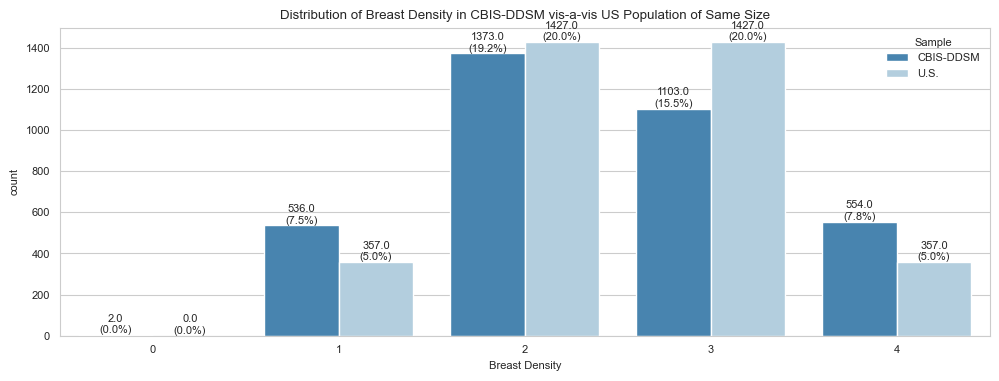

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(data=density,x='Breast Density', hue="Sample", ax=ax, title ="Distribution of Breast Density in CBIS-DDSM vis-a-vis US Population of Same Size")

If we were to perform a goodness of fit test on the two samples, the null hypothesis of breast density in CBIS-DDSM and breast density in the US Population originating from the same distribution, would likely be rejected. The CBIS-DDSM has fatter tails on both ends of the distribution. Some right skew is extant as well.

#### Left Right

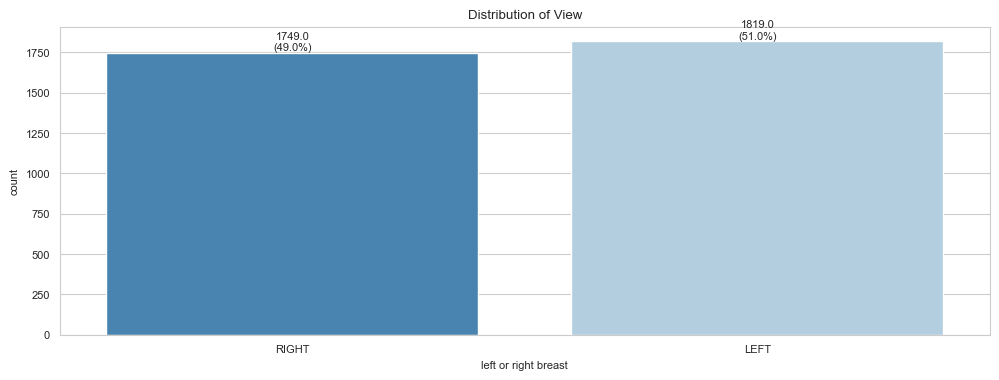

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='left or right breast', ax=ax, title ="Distribution of View")

There are slightly more left views than right; still, the dataset is fairly balanced in this regard for what that's worth.

#### Image View
In mammography, each breast is typically imaged with two different views: the mediolateral oblique (MLO) view and cranial caudal (CC) view. The MLO view is taken from the center of the chest outward, while the CC view is taken from above the breast downward.
```{figure} ../figures/standard_image_views.jpg
:name: image_views_ref
Standard Radiological Views in Mammography
```
The CBIS-DDSM distribution of the two views {ref}`image_views_ref` are as follows.

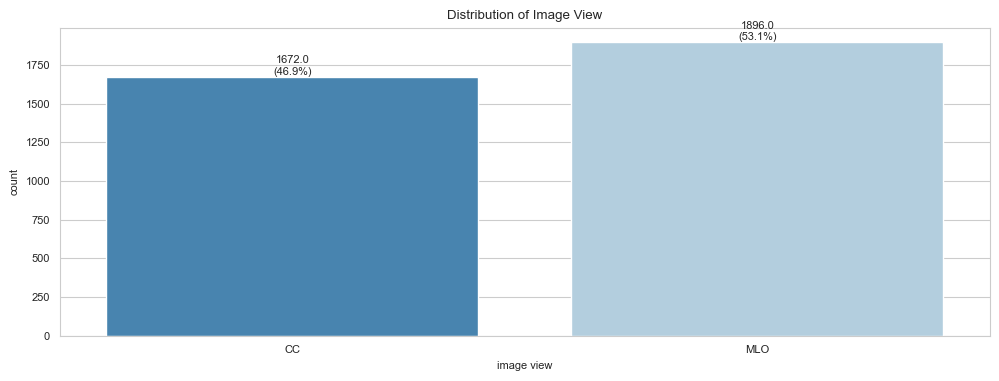

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='image view', ax=ax, title ="Distribution of Image View")

Mediolateral oblique views slightly outnumber craniocaudal views.

#### Abnormality Id

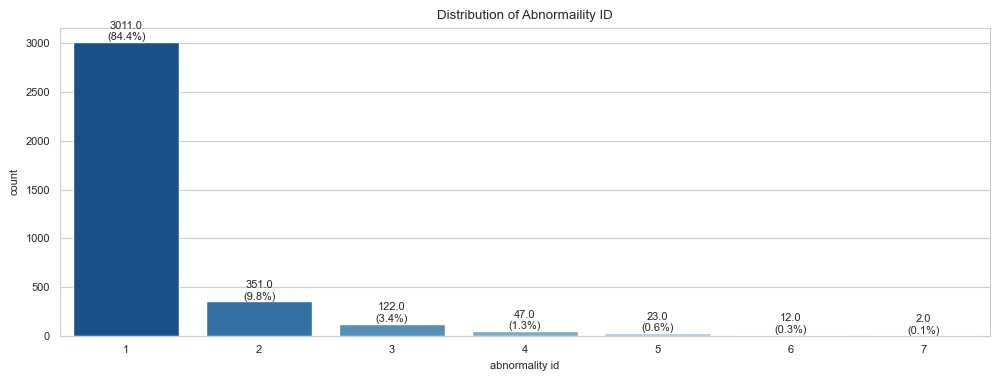

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='abnormality id', ax=ax, title ="Distribution of Abnormaility ID")

A plurality of patients present only one abnormality.

#### Abnormality Type
**Breast calcifications**, one of the two types of abnormalities in the CBIS-DDSM, are calcium deposits within breast tissue that appear as white flecks or spots on a mammogram. Common on mammograms, and especially prevalent after age 50, breast calcifications are usually benign; yet, certain patterns, shapes and appearance, may indicate breast cancer or precancerous changes to tissue {cite}`BreastCalcificationsMayo`. 

**Breast mass** is a lump or growth of breast tissue that differs in its density relative to that of the tissue surrounding it. Masses have a range of causes, including breast cysts, fibrocycstic breast changes, fibroadenomas, injury, infection, intraductal papilloma, lipoma and breast cancer; however, most cases (80% according to Cleveland Clinic) are non-cancerous {cite}`BreastLumpsCauses`.



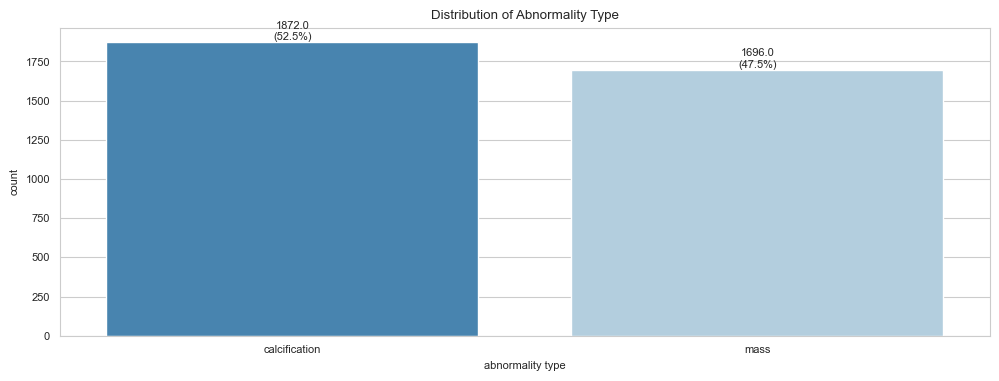

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='abnormality type', ax=ax, title ="Distribution of Abnormality Type")

Calcifications make up about 53% of the cases.

#### BI-RADS Assessment
Mammographers have assigned each case a BI-RADS score, from 0 to 6, each having a specific clinical meaning and suggested follow-up care {cite}`MammogramResultsBIRADS2022`.
- Category 0 means the findings are unclear. The radiologist will need more images to determine a score.
- Category 1 means the findings are negative and the breast tissue appears normal. No masses, calcifications, asymmetry or other abnormalities have been found. 
- Category 2 means the findings are benign, which is also negative for cancer. While a mass, calcification or other abnormality may have been detected, it’s not cancerous.
- Category 3 means the findings are probably benign. While a mass, calcification or other abnormality may have been found, it’s most likely not cancerous.
- Category 4 means the findings suspect cancer. Category 4 has three subcategories based on the chance of cancer:
  - 4A means a low chance of cancer (2 to 10 percent).
  - 4B means a moderate chance of cancer (10 to 50 percent).
  - 4C means a high chance of cancer (50 to 95 percent).
- Category 5 means the findings highly suggest cancer. According to the American Cancer Society {cite}`MammogramResultsUnderstanding`, category 5 findings have a 95 percent chance or higher of being cancerous.
- Category 6 means cancer was previously diagnosed using a biopsy.

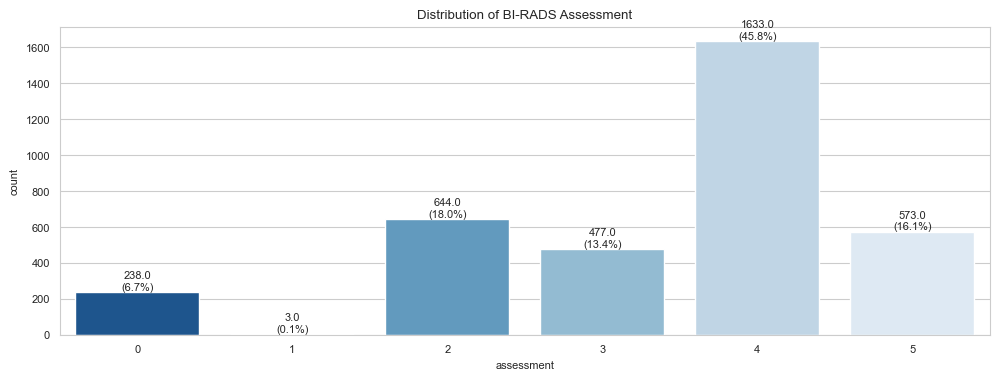

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='assessment', ax=ax, title ="Distribution of BI-RADS Assessment")

#### Sublety
Each case contains a mammagrapher-assigned "subtlety rating" on a scale of 1 (subtle) to 5 (obvious).

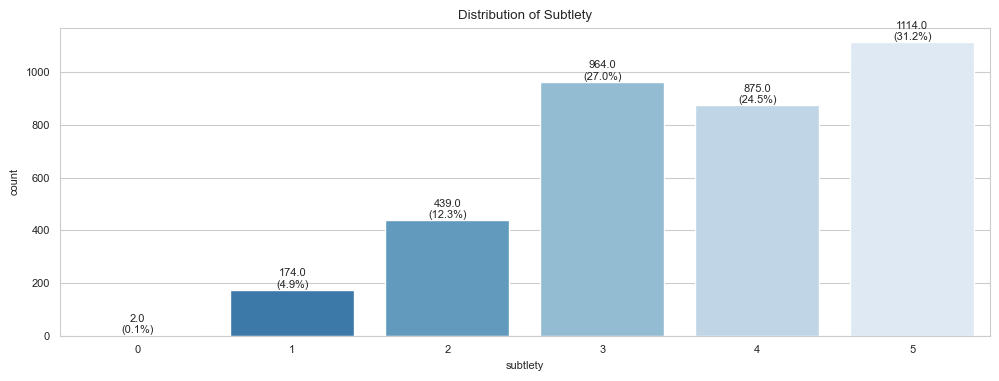

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety")

Two observations have a subtlety of zero, outside of the rating scale of 1 to 5. If were were to include subtlety in a classification model, we mignt consider excluding the 'out of subtlety rating scale' observations from modeling. An alternative would be to assign zero values to the average subtlety, or average subtlety by view. 

#### Pathology
CBIS-DDSM has categorized the cases in terms of three pathologies.
1. **Malignant**: refers to the presence of cancerous cells that have the ability to spread to other sites in the body (metastasize) or to invade nearby  destroy tissues. Malignant cells tend to have fast, uncontrolled growth and do not die normally due to changes in their genetic makeup. Malignant cells that are resistant to treatment may return after all detectable traces of them have been removed or destroyed {cite}`MalignancyMedlinePlusMedical`.
2. **Benign**: refers to a non-cancerous calcification or mass that tends to grow only in one place. They cannot spread or invalid other parts of the body. Even so, they can be dangerous if they press on vital organs, such as the brain {cite}`BenignTumors`.
3. **Benign without Callback**: refers to an examination determined not to contain a cancer using only the screening exam films. No additional films or biopsy was done. These cases, however, contained something interesting enough for the radiologist to mark {cite}`DDSMOverviewVolume`.

The stratification of pathology in CBIS-DDSM follows.

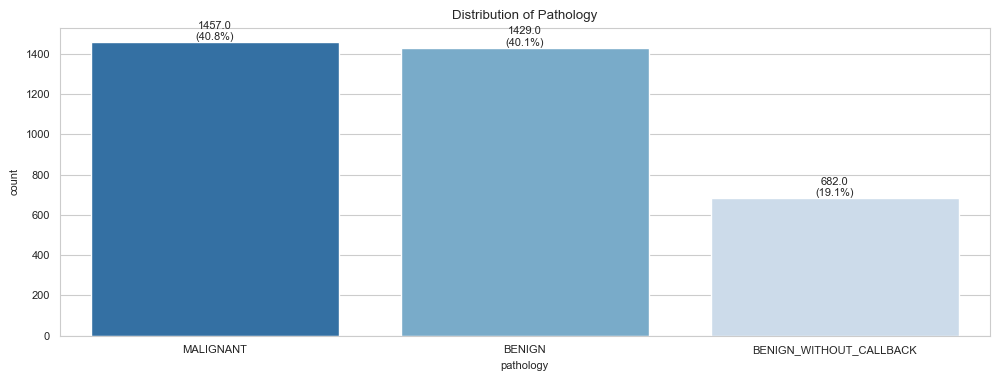

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology")

#### Diagnosis
Finally, we've created a variable to capture whether the pathology was malignant or benign.

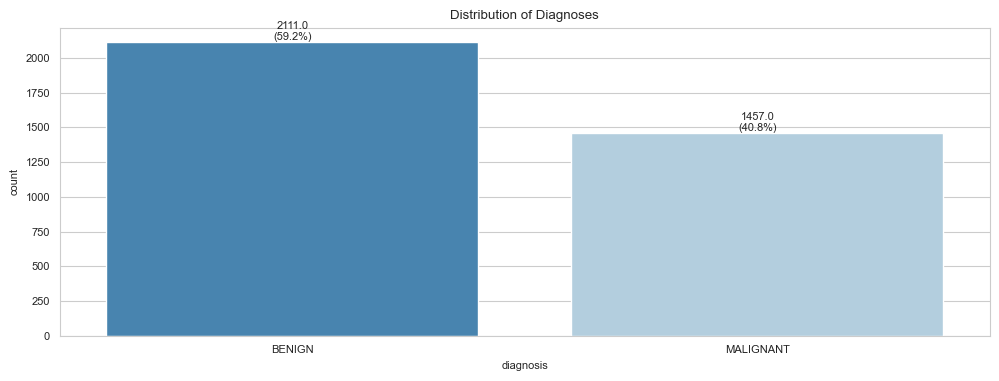

In [6]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='diagnosis', ax=ax, title ="Distribution of Diagnoses")

Nearly 60% (59.2%) of the cases were benign and 40.8% were malignant.

### Bivariate Analysis

At this stage, we are examining bivariate relationships between the variables and between the variables and the binary target, diagnosis. We'll conduct the pairwise analyses in the following order:
- Breast Density
- Image View
- Abnormality Type
- Assessment
- Subtlety
- Diagnosis

Each of the above variables will be evaluated in non-repeating pairwise permutations, starting with Breast Density.

#### Breast Density Bivariate Analysis
Recall that we have four breast density categories:
1. Almost entirely fatty
2. Scattered areas of fibroglandular density
3. Heterogeneously dense
4. Extremely dense

We'll examine breast density and its relationships with:  
- image view
- abnormality type
- assessment
- subtlety
- diagnosis


##### Density and Image View

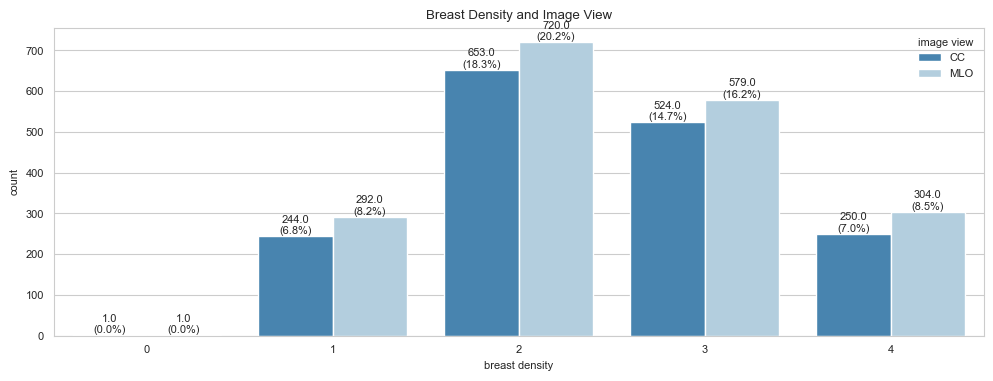

In [17]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='breast density', hue='image view', ax=ax, title ="Breast Density and Image View")

Recall from the univariate analysis, we have a larger number of mediolateral oblique (MLO) views (~53%) in CBIS-DDSM. Does this figure suggest a difference in density assessments by image view? Would this difference, if any, be attributable to the randomization of our sample? Let's conduct a chi-square test under the null hypothesis of independence between image view and breast density.

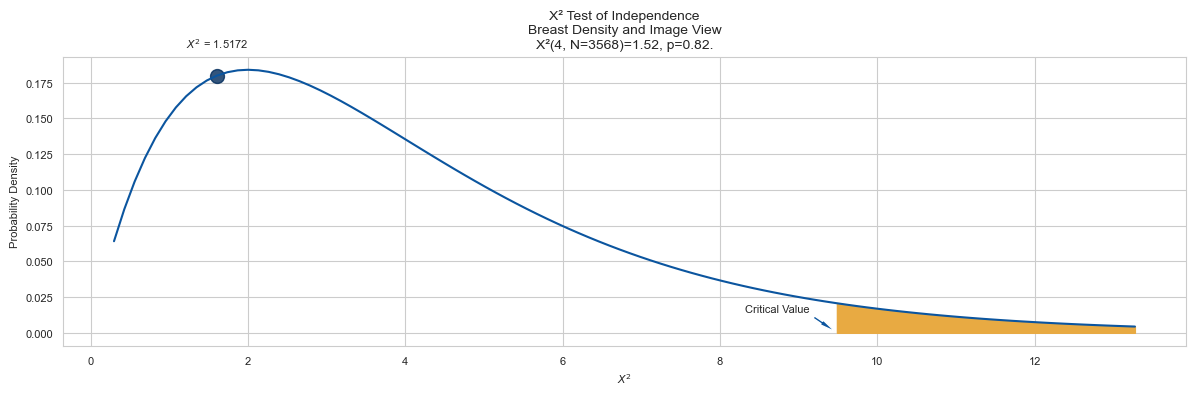

In [18]:
df = ds.as_df()
# Compute the contingency table or crosstab
crosstab = pd.crosstab(df['breast density'], df['image view'])
# Execute the ChiSquare Test of Independence and prepare the result.
statistic, pvalue, dof, _ = stats.chi2_contingency(crosstab)
result = f"X² Test of Independence\nBreast Density and Image View\nX²({dof}, N={len(df)})={round(statistic,2)}, p={round(pvalue,2)}."
# Plot the statistic and critical region.
ds.plot.x2testplot(statistic=statistic, dof=dof, result=result, alpha=0.05)

Our $X^2$ Test of Independence indicates the probability of encountering a $X^2$ statistic at least as extreme as 1.52, under the null hypothesis is 0.82, with alpha significance of 0.05, 4 degrees of freedom, and a sample size of 3568. Hence, the null hypothesis of independence is *not* rejected. The evidence is not in favor of dependence between image view and breast density.

**Key Observations**
- Data support the inference of independence between breast density and image view. IOW, image view doesn't seem to affect assessments of breast density. 
- The counts reflect the fact that there are more MLO view samples in the dataset.

##### Breast Density and Abnormality Type
What, if any, is the relationship between breast density and abnormality type.

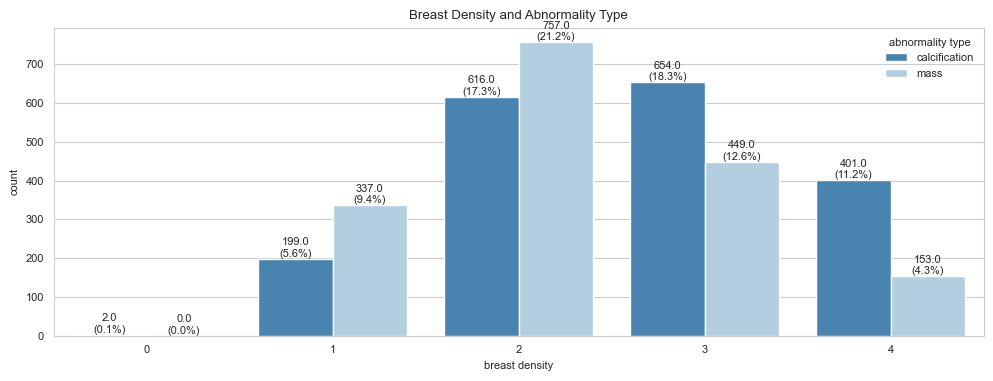

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='breast density', hue='abnormality type', ax=ax, title ="Breast Density and Abnormality Type")

Once again, we see the two zero density observations from the univariate analysis. We'll ignore those for now. 

**Key Observations**
- Breast density and abnormality type do not appear to be independent.
- The proportion of calcification abnormalities increases with breast density. Masses appear to be more prevalent at the lower density levels (1 and 2). 

##### Breast Density BI-RADS Assessment
Recall from the univariate analysis that BI-RADS Assessment categories are in [0,6], where: 
- Category 0 means the findings are unclear. More images needed.
- Category 1 means the findings are negative and the breast tissue appears normal.
- Category 2 means the findings are benign, which is also negative for cancer. 
- Category 3 means the findings are probably benign. 
- Category 4 means the findings suspect cancer. 
- Category 5 means the findings highly suggest cancer. 

Note that category 6, meaning cancer was previously diagnosed using a biopsy, is not included in the dataset.

Let's take a look at breast density by BI-RADS assessment.

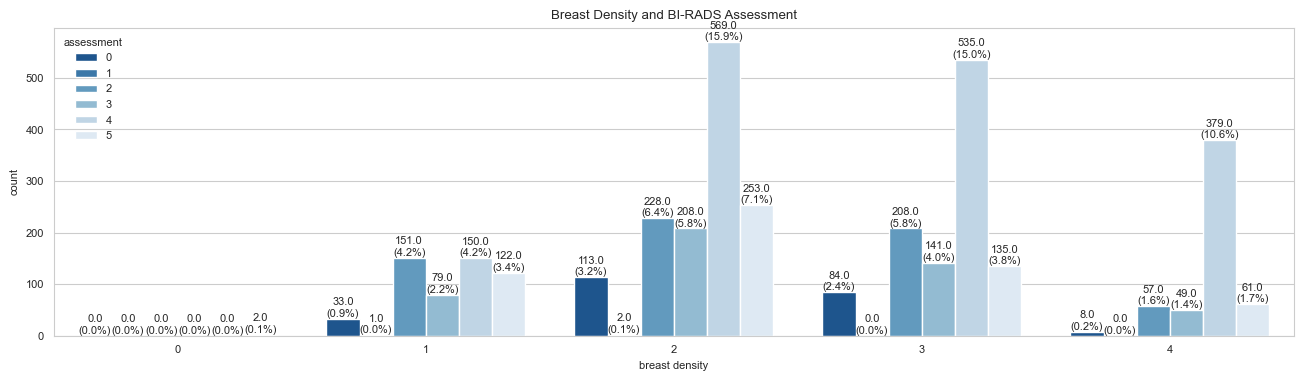

In [21]:
fig, ax = plt.subplots(figsize=(16,4))
ds.plot.countplot(x='breast density', hue='assessment', ax=ax, title ="Breast Density and BI-RADS Assessment")

Now, BI-RADS assessment by breast density.

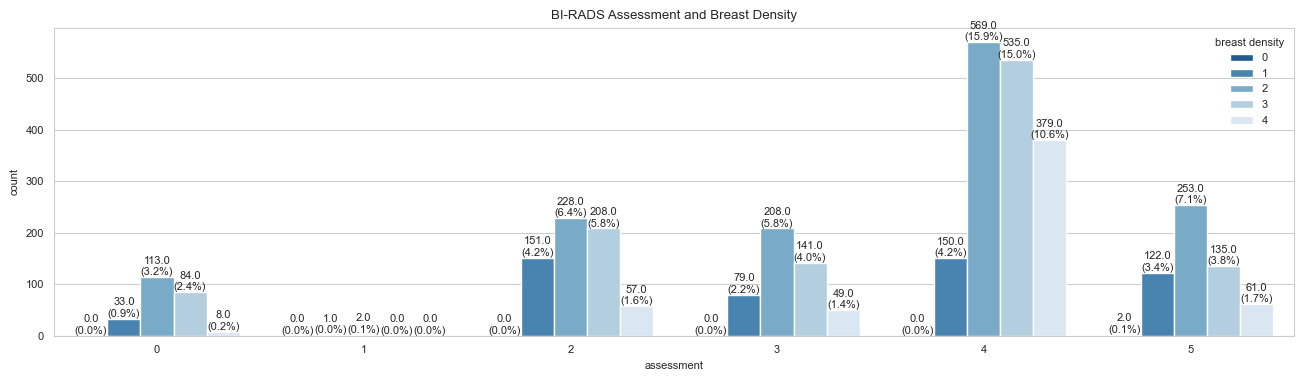

In [24]:
fig, ax = plt.subplots(figsize=(16,4))
ds.plot.countplot(hue='breast density', x='assessment', ax=ax, title ="BI-RADS Assessment and Breast Density")

**Key Observations**
- BI-RADS assessment and breast density do not appear to be independent.
- Breast density category 2 and above have signficantly higher assessments of suspected cancer, but not highly suggested cancer.  
- Assessments of *suspected* cancer tend to increase with breast density.

##### Breast Density and Subtlety
Recall, subtlety ranges from 0 (very subtle) to 5 (obvious). Let's examine breast density by subtlety.

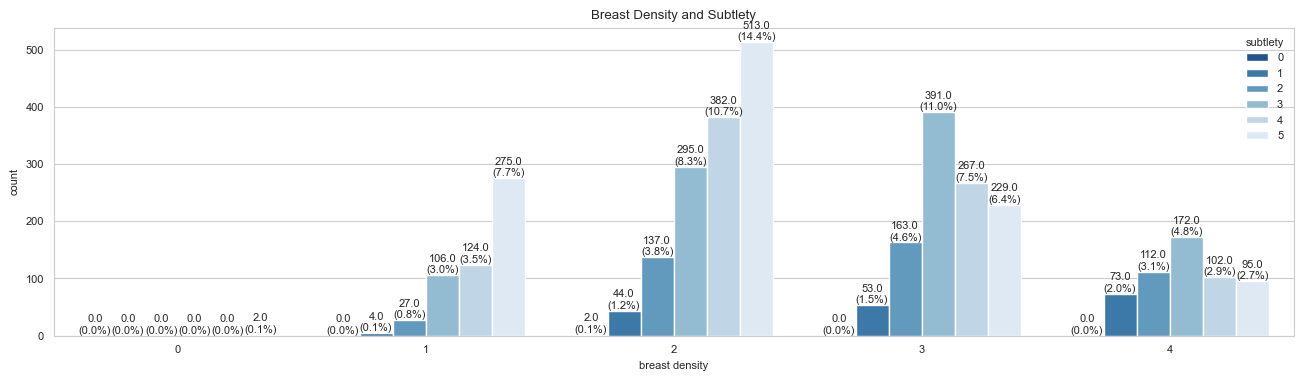

In [25]:
fig, ax = plt.subplots(figsize=(16,4))
ds.plot.countplot(x='breast density', hue='subtlety', ax=ax, title ="Breast Density and Subtlety")

Now, let's plot subtlety by breast density.

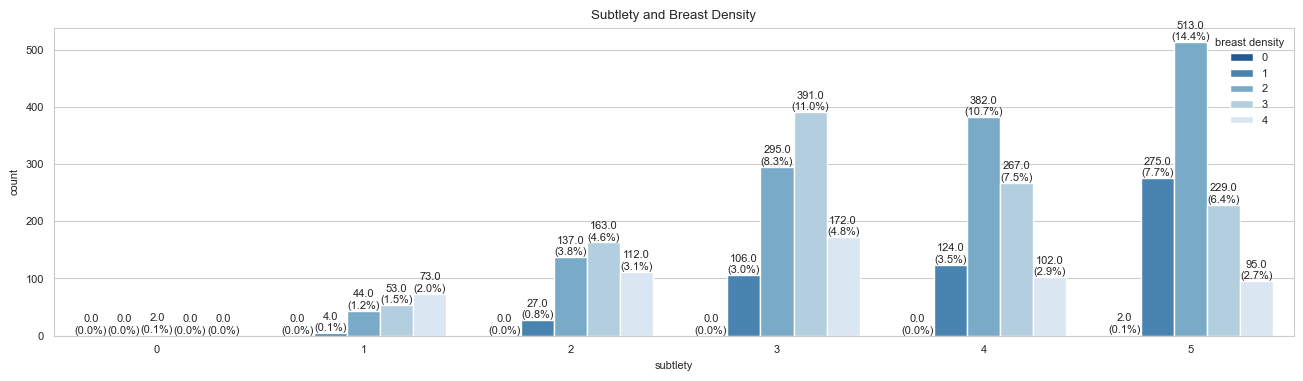

In [7]:
fig, ax = plt.subplots(figsize=(16,4))
ds.plot.countplot(x='subtlety', hue='breast density', ax=ax, title ="Subtlety and Breast Density")

**Key Observations**
- Subtlety and breast density appear to have a dependent relationship.
- Subtlety appears to increase with breast density.

##### Breast Density and Diagnosis
To what degree does breast density relate to a diagnosis of breast cancer.

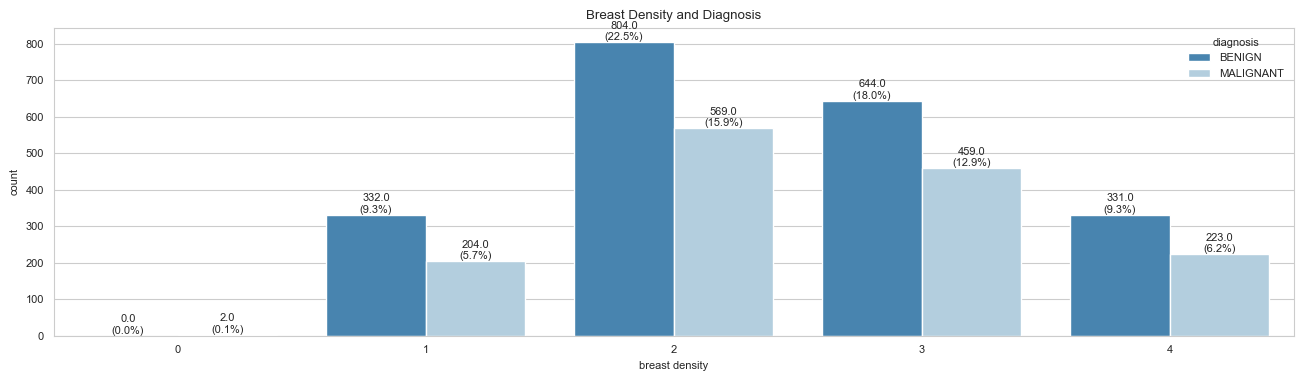

In [9]:
fig, ax = plt.subplots(figsize=(16,4))
ds.plot.countplot(x='breast density', hue='diagnosis', ax=ax, title ="Breast Density and Diagnosis")

The proportions of cancer and non-cancer cases don't appear to change by breast density category. Is this supported by an independence test?

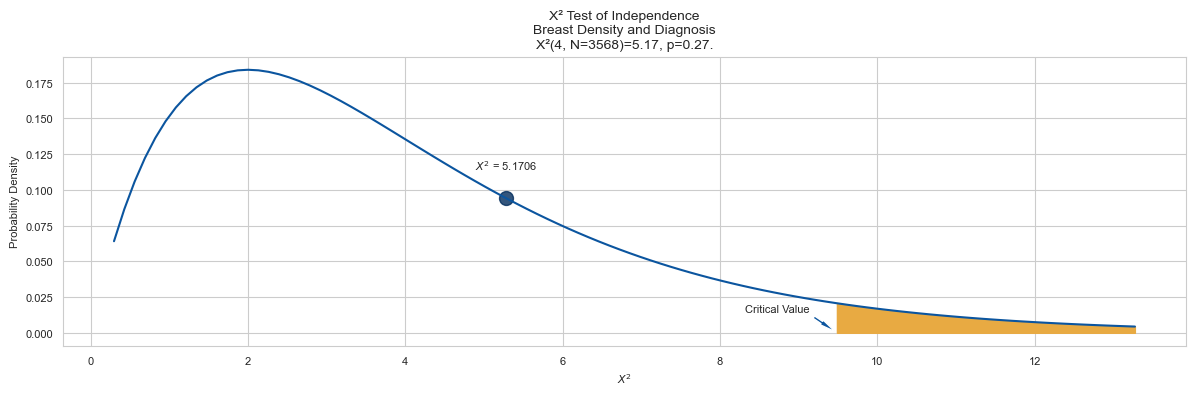

In [10]:
crosstab = pd.crosstab(df['breast density'], df['diagnosis'])
statistic, pvalue, dof, _ = stats.chi2_contingency(crosstab)
result = f"X² Test of Independence\nBreast Density and Diagnosis\nX²({dof}, N={len(df)})={round(statistic,2)}, p={round(pvalue,2)}."
ds.plot.x2testplot(statistic=statistic, dof=dof, result=result, alpha=0.05)

Yes. These results are in favor of the null hypothesis of independence between breast density and diagnosis.
**Key Observations**
- Breast density and diagnosis appear to be independent.

##### Breast Density Bivariate Analysis Summary
Several observations deserve highlighting.
-	Abnormality Type: Breast density and abnormality type appear to be related.  The proportion of calcification abnormalities increases with breast density. Masses appear to be more prevalent at the lower density levels (1 and 2).
-	BI-RADS Assessment: Breast density and BI-RADS assessment appear to be associated. Assessments of *suspected* cancer tend to increase with breast density.
-	Subtlety: A relationship between breast density and subtlety appears to be extant. Subtlety appears to increase with breast density.
-	Diagnosis: Breast density and diagnosis do not appear to be related.  This was validated by our $X^2$ Test of Independence $X^2(4,N=3568)=5.17, p=0.27.
